In [1]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

In [2]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

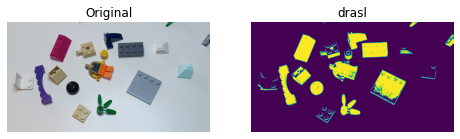

In [3]:
im_org = io.imread('data/lego_4_small.png')
gray = color.rgb2gray(im_org)
thres = threshold_otsu(gray)
newim = gray < thres
show_comparison(im_org,newim,'drasl')

In [6]:
image_clear = segmentation.clear_border(newim)
footprint = morphology.disk(5)
im_process = morphology.binary_closing(image_clear, footprint)
im_open = morphology.binary_opening(im_process, footprint)

In [7]:
label_img = measure.label(im_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


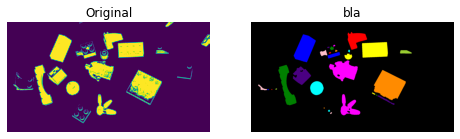

In [8]:
labeled = color.label2rgb(label_img)
show_comparison(newim,labeled,'bla')

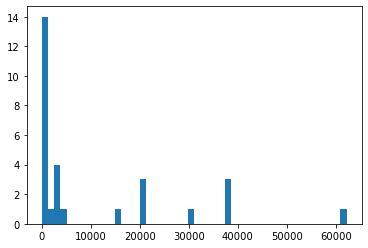

In [9]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

In [11]:
!python data/Ex5-BlobAnalysisInteractive.py

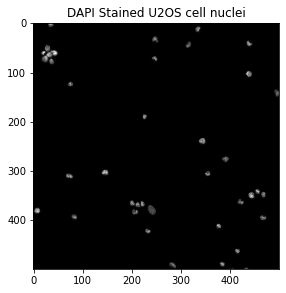

In [12]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

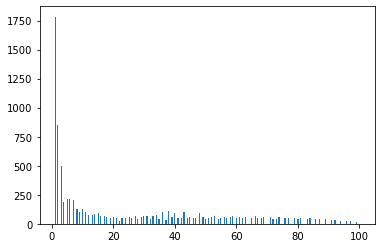

In [13]:
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

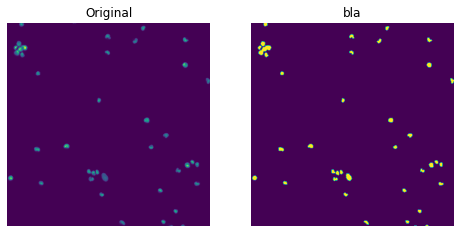

In [15]:
thres = threshold_otsu(img_gray)
show_comparison(img_gray,img_gray>thres,'bla')

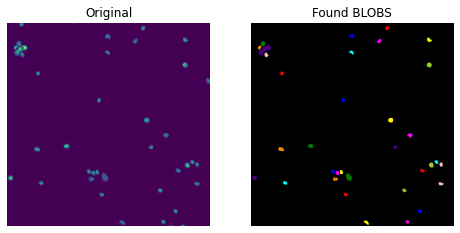

In [18]:
img_bin = img_gray > thres
img_bin_c = segmentation.clear_border(img_bin)
label_img = measure.label(img_bin_c)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, 'Found BLOBS')

In [20]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
print(areas)

[ 71  88  84  78 104 360  60  68  76 115  67  63 114  93 107  66 106  61
  68 111  68  73  64  71 192 103  78  69  73  68  65  63  75  60]


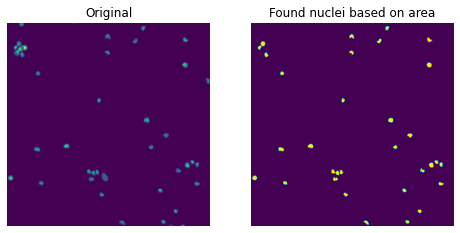

In [21]:
min_area = np.min(areas)
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

In [22]:
perimeters = np.array([prop.perimeter for prop in region_props])

Text(0, 0.5, 'perimeter')

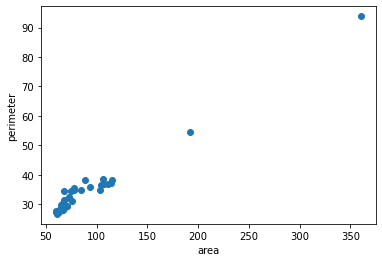

In [28]:
plt.scatter(areas,perimeters)
plt.xlabel('area')
plt.ylabel('perimeter')
#plt.plot(perimeters)

In [29]:
def circularity(area,perimeter):
    circ = (4*math.pi*area)/(perimeter**2)
    return circ
circs = circularity(areas,perimeters)

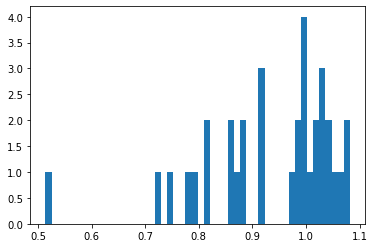

In [31]:
plt.hist(circs, bins=50)
plt.show()

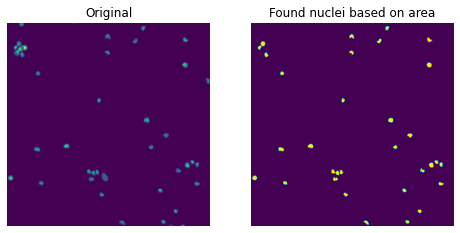

In [32]:
min_circ = 0.7
label_img_filter = label_img
for region in region_props:
	circ = circularity(region.area,region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

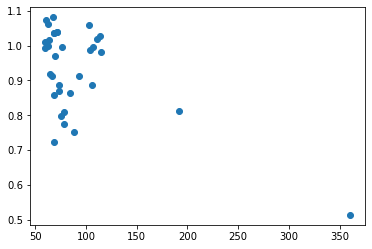

In [33]:
plt.scatter(areas,circs)

In [ ]:
def cell_counting(img_gray, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = segmentation.clear_border(img_bin)

    # Label image
    label_img = measure.label(img_c_b)

    # Extract properties
    region_props = measure.regionprops(label_img)

    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            # set the pixels in the invalid areas to background
            n_nuclei = n_nuclei - 1
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei